In [1]:
import copy
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pyDOE2 import lhs
from scipy.integrate import odeint

T_START = 0
T_S = 5
T_END = 20

NUM_EPOCHS = 30000
LEARNING_RATE = 1e-4
NUM_POINTS = 100
NUM_COLLOCATION = 1000
PATIENCE = 100
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


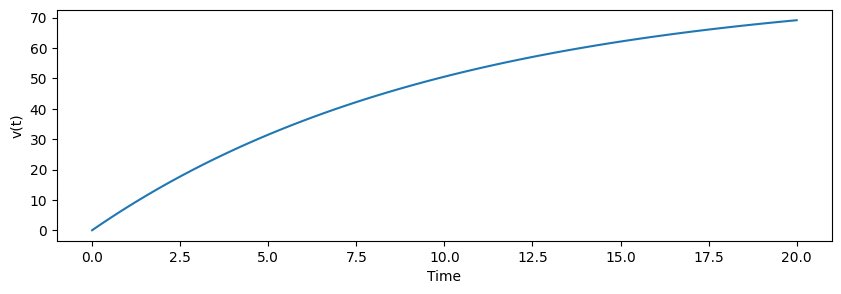

In [48]:
def p(t):
    return 100

def ode_model(v, t, p):
    mass = 500
    b = 50
    K = .8
    return 1/mass * (-v * b + K * b * p)

# Set the initial conditions
v0 = 0
t = np.linspace(T_START, T_END, 100)

# Solve the ODEs
sol = odeint(ode_model, v0, t, args=(100,))

# Plot the solution
plt.figure(figsize=(10,3))
plt.plot(t, sol)
plt.xlabel('Time')
plt.ylabel('v(t)')
plt.show()


In [49]:
# Generate a dataset
def generate_uniform(num_points: int) -> pd.DataFrame:
    df = pd.DataFrame(columns=["t", "v", "p"])
    df["v"] = np.random.uniform(0.0, 40, num_points)
    df["p"] = np.random.uniform(1.0, 100, num_points)
    df["t"] = 0.0
    return df

def generate_lhs(v_range: list, p_range: list, t_range: list, num_points: int) -> pd.DataFrame:
    # Use LHS to generate samples in the unit interval [0, 1]
    lhs_samples = lhs(3, samples=num_points)  # 3 dimensions: x1, x2, u
    # Scale the samples to the desired ranges
    v_samples = v_range[0] + (v_range[1] - v_range[0]) * lhs_samples[:, 0]
    p_samples = p_range[0] + (p_range[1] - p_range[0]) * lhs_samples[:, 1]
    t_samples = t_range[0] + (t_range[1] - t_range[0]) * lhs_samples[:, 2]
    # Combine the results
    df = pd.DataFrame({"t": t_samples, "v": v_samples, "p": p_samples})  
    return df

# df = generate_uniform(NUM_POINTS)
df = generate_lhs(v_range=[0.0, 40.0], p_range=[1.0, 100], t_range=[0, 0], num_points=NUM_POINTS)
print(f"Dataset shape: {df.shape}")

Dataset shape: (100, 3)


In [50]:
def np_to_ts(x):
    return (
        torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(DEVICE)
    )

def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc4(x)
        return x


def loss_fn(net: PINN, X_train: torch.Tensor):
    df_col = generate_lhs(v_range=[0.0, 40.0], p_range=[1.0, 100], t_range=[0, T_S], num_points=NUM_COLLOCATION)
    t_col = np_to_ts(df_col["t"].values).to(DEVICE)
    v_col = np_to_ts(df_col["v"].values).to(DEVICE)
    p_col = np_to_ts(df_col["p"].values).to(DEVICE)
    
    X_col = torch.cat((t_col, v_col, p_col), 1).to(DEVICE)

    preds = net.forward(X_col)

    v_pred = preds

    dvdt = grad(v_pred, t_col)[0]
    
    error_ode = nn.MSELoss()(dvdt, 1/500 * (-v_pred * 50 - 0.8 * 50 + p_col))
    
    return error_ode

In [51]:
t_train = np_to_ts(df["t"].values)
v_train = np_to_ts(df["v"].values)
p_train = np_to_ts(df["p"].values)

X_train = torch.cat([t_train, v_train, p_train], dim=1)
y_train = v_train.view(-1,1)

In [52]:
net = PINN(3, 1).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Loss weights
w_data, w_ode, w_ic = 1, 1, 1

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net.forward(X_train)

    loss_data = nn.MSELoss()(preds, y_train)

    loss_ode = loss_fn(net, X_train)

    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}"
        )

    if epoch >= EARLY_STOPPING_EPOCH:
        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 1000
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")
                net.load_state_dict(best_model_weights)
                break

Epoch 0, Loss_data: 544.1678, Loss_ode: 0.0042
Epoch 100, Loss_data: 512.6713, Loss_ode: 0.0028
Epoch 200, Loss_data: 481.3265, Loss_ode: 0.0123
Epoch 300, Loss_data: 452.4966, Loss_ode: 0.0325
Epoch 400, Loss_data: 427.4380, Loss_ode: 0.0600
Epoch 500, Loss_data: 406.2548, Loss_ode: 0.0914
Epoch 600, Loss_data: 388.1985, Loss_ode: 0.1249
Epoch 700, Loss_data: 372.3986, Loss_ode: 0.1603
Epoch 800, Loss_data: 358.2746, Loss_ode: 0.1968
Epoch 900, Loss_data: 345.5108, Loss_ode: 0.2354
Epoch 1000, Loss_data: 333.8085, Loss_ode: 0.2666
Epoch 1100, Loss_data: 322.7600, Loss_ode: 0.3003
Epoch 1200, Loss_data: 312.5484, Loss_ode: 0.3408
Epoch 1300, Loss_data: 302.9664, Loss_ode: 0.3795
Epoch 1400, Loss_data: 293.9044, Loss_ode: 0.4113
Epoch 1500, Loss_data: 285.2810, Loss_ode: 0.4469
Epoch 1600, Loss_data: 276.8414, Loss_ode: 0.4895
Epoch 1700, Loss_data: 268.7828, Loss_ode: 0.5351
Epoch 1800, Loss_data: 261.0420, Loss_ode: 0.5636
Epoch 1900, Loss_data: 253.5195, Loss_ode: 0.6006
Epoch 2000, 

In [53]:
# pickle save the model
torch.save(net, "pinc_vehicle_trained.pth")

### Autoregression

In [54]:
# Load the model
net = torch.load("pinc_vehicle_trained.pth")

In [55]:
# Create validation set
t_val = t.copy()
v_val = sol[:, 0].copy()
p_val = [p(t) for _ in range(len(t_val))]
X_val = torch.tensor(
    np.array([t_val, p_val, p_val]).T, dtype=torch.float32
).to(DEVICE)
y_val = torch.tensor(v_val, dtype=torch.float32).to(DEVICE)

In [56]:
v_0 = v_val[0]
p_0 = p_val[0]

v_preds = []
for i in range(1, len(t_val)):
    y_k = net.forward(
        torch.tensor([T_S, v_0, 100], dtype=torch.float32).to(DEVICE)
    )
    v_0 = v_val[i]  # Yeah! Control
    v_preds.append(y_k[0].item())

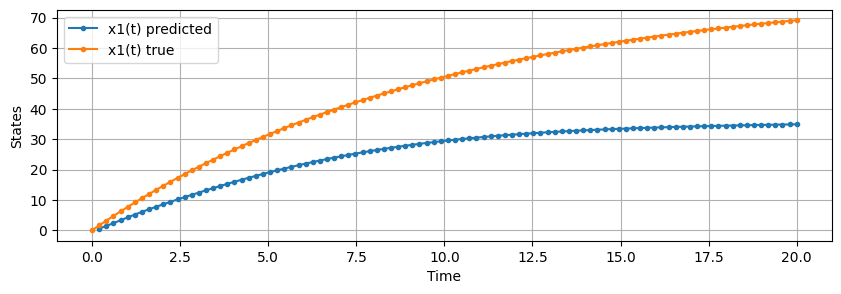

In [58]:
# Plot x1_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], v_preds, marker="o", markersize=3, label="x1(t) predicted")
plt.plot(t_val, v_val, marker="o", markersize=3, label="x1(t) true")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

# Control

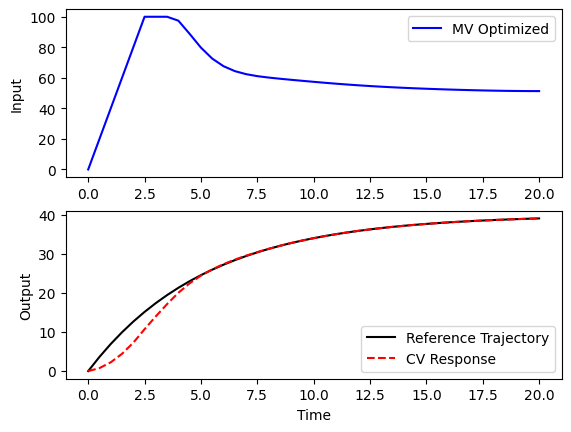

In [14]:
from gekko import GEKKO

m = GEKKO()
m.time = np.linspace(0,20,41)

# Parameters
mass = 500
b = m.Param(value=50)
K = m.Param(value=0.8)

# Manipulated variable
p = m.MV(value=0, lb=0, ub=100)
p.STATUS = 1  # allow optimizer to change
p.DCOST = 0.1 # smooth out gas pedal movement
p.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
v = m.CV(value=0)
v.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
v.SP = 40     # set point
v.TR_INIT = 1 # set point trajectory
v.TAU = 5     # time constant of trajectory

# Process model
m.Equation(mass*v.dt() == -v*b + K*b*p)

m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
with open(m.path+'//results.json') as f:
    results = json.load(f)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',label='MV Optimized')
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
plt.plot(m.time,results['v1.tr'],'k-',label='Reference Trajectory')
plt.plot(m.time,v.value,'r--',label='CV Response')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

# Manually

In [31]:
from sklearn.linear_model import LinearRegression
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

lr = LinearRegression()
train = pd.DataFrame(columns=["t", "v", "p"])
train['t'] = t
train['v'] = sol
train['p'] = 100
X_train = train[['t', 'p']]
y_train = train['v']

lr.fit(X_train, y_train)

LinearRegression()

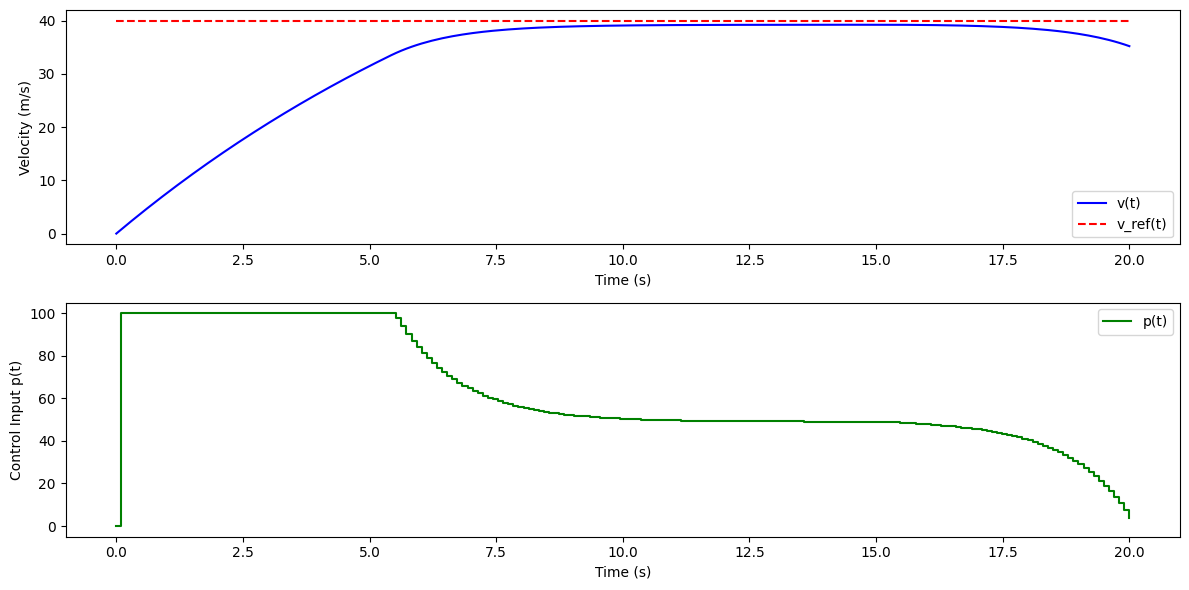

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Define the system parameters
mass = 500
b = 50
K = 0.8
T_horizon = T_S  # Prediction horizon

# Define the system dynamics
def ode_model(t, v, p):
    return (1/mass) * (-v * b + K * b * p)

# Define the cost function for MPC
def mpc_cost(p_sequence, v_current, v_ref_traj, dt):
    # Simulate the system over the prediction horizon
    v = v_current
    cost = 0
    for i in range(len(p_sequence)):
        # Update the state using the system dynamics
        v = v + ode_model(0, v, p_sequence[i]) * dt
        # Calculate the cost (tracking error + control effort)
        tracking_error = (v - v_ref_traj[i])**2
        control_effort = 0.01 * (p_sequence[i])**2  # Small penalty on control effort
        cost += tracking_error + control_effort
    return cost

# MPC setup
def mpc_control(v_current, v_ref_traj, dt, prediction_steps):
    # Initial guess for control inputs
    p0 = np.zeros(prediction_steps)

    # Optimization bounds for control inputs
    bounds = [(0, 100)] * prediction_steps  # Limit control between -10 and 10

    # Minimize the cost function to find optimal control sequence
    result = minimize(
        mpc_cost, p0, args=(v_current, v_ref_traj, dt), bounds=bounds, method='SLSQP'
    )
    # Return the first control input from the optimal sequence
    return result.x[0]

# Time settings
dt = 0.1  # Time step
total_time = 20  # Total simulation time
time_steps = int(total_time / dt)

# Reference trajectory for v(t)
v_ref = np.ones(time_steps) * 40  # Desired constant velocity of 5 m/s

# Simulation storage
v_values = np.zeros(time_steps)
p_values = np.zeros(time_steps)
t_values = np.linspace(0, total_time, time_steps)

# Initial condition
v_values[0] = 0  # Initial velocity

# Simulate using MPC
for i in range(1, time_steps):
    # Extract reference trajectory for the current prediction horizon
    v_ref_horizon = v_ref[i:i + int(T_horizon / dt)]
    
    # Use MPC to compute control action
    p = mpc_control(v_values[i - 1], v_ref_horizon, dt, len(v_ref_horizon))
    
    # Apply the control action and simulate one time step
    sol = solve_ivp(ode_model, [t_values[i-1], t_values[i]], [v_values[i-1]], args=(p,))
    v_values[i] = sol.y[0, -1]
    p_values[i] = p

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_values, v_values, label='v(t)', color='b')
plt.plot(t_values, v_ref, 'r--', label='v_ref(t)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(2, 1, 2)
plt.step(t_values, p_values, label='p(t)', color='g', where='post')
plt.xlabel('Time (s)')
plt.ylabel('Control Input p(t)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
zzz